In [ ]:
!pip install tf_keras_vis
# !pip install split-folders
# import splitfolders


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras.backend as K
from scipy.ndimage import zoom
from scipy.stats import f_oneway
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import VGG16, InceptionV3, Xception, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils import normalize
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 953.2 kB/s eta 0:00:00


In [ ]:
# import zipfile

# zip_file_path = "/content/drive/MyDrive/Rotation/diabetic-retinopathy-224x224-2019-data.zip"

# # Extract the contents of the zip file in the same directory
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(path="/content/drive/MyDrive/Rotation/")


In [ ]:
# import os

# def walk_through_dir(dir_path):

#   for dirpath, dirnames, filenames in os.walk(dir_path):
#     print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


# walk_through_dir("/content/drive/MyDrive/Rotation/Colored")

There are 5 directories and 0 images in '/content/drive/MyDrive/Rotation/Colored'.
There are 0 directories and 999 images in '/content/drive/MyDrive/Rotation/Colored/Moderate'.
There are 0 directories and 370 images in '/content/drive/MyDrive/Rotation/Colored/Mild'.
There are 0 directories and 1805 images in '/content/drive/MyDrive/Rotation/Colored/No_DR'.
There are 0 directories and 295 images in '/content/drive/MyDrive/Rotation/Colored/Proliferate_DR'.
There are 0 directories and 193 images in '/content/drive/MyDrive/Rotation/Colored/Severe'.


In [ ]:
# data_path = "/content/drive/MyDrive/Rotation/Colored"

# splitfolders.ratio(data_path, output="/content/drive/MyDrive/Rotation/Colored", seed=42, ratio=(0.8, 0.2))

# input_path = "/content/drive/MyDrive/Rotation/Colored"

Copying files: 3662 files [14:59,  4.07 files/s]


In [ ]:
# Normalization and Data Augmentation
def preprocess_image(image, label):
    # Resize and augmentations
    image = tf.image.resize(image, [224, 224])
    image = tf.image.random_flip_left_right(image)
    # Add any other transformations here

    # Normalize
    image = (image / 255.0 - tf.constant([0.485, 0.456, 0.406])) / tf.constant([0.229, 0.224, 0.225])

    return image, label

# Load datasets using image_dataset_from_directory
def load_dataset(path, is_training):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',  # or 'int' for integer labels
        class_names=None,
        color_mode='rgb',
        batch_size=32,
        image_size=(224, 224),
        shuffle=is_training,
        seed=123,  # for reproducibility
        validation_split=None,
        subset=None,
    )

    # Apply preprocessing
    dataset = dataset.map(preprocess_image)

    return dataset

# Paths to your train and validation directories
train_path = '/content/drive/MyDrive/Rotation/Colored/train'
val_path = '/content/drive/MyDrive/Rotation/Colored/val'

# Load datasets
train_dataset = load_dataset(train_path, is_training=True)
validation_dataset = load_dataset(val_path, is_training=False)


Found 2929 files belonging to 5 classes.
Found 733 files belonging to 5 classes.


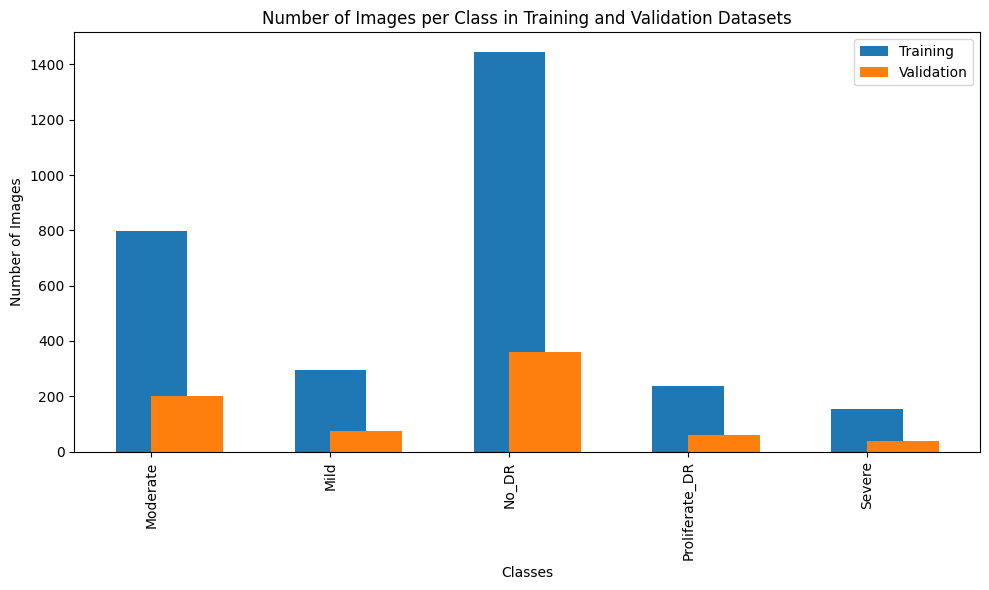

In [ ]:
import os
import matplotlib.pyplot as plt

# Paths to training and validation directories
train_path = '/content/drive/MyDrive/Rotation/Colored/train'
val_path = '/content/drive/MyDrive/Rotation/Colored/val'

# Function to count files in each class directory
def count_files_in_classes(path):
    counts = {}
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Counting files in each class for both training and validation sets
train_counts = count_files_in_classes(train_path)
val_counts = count_files_in_classes(val_path)

# Plotting the results
plt.figure(figsize=(10, 6))

# Data for plotting
classes = list(train_counts.keys())
train_sizes = [train_counts[cls] for cls in classes]
val_sizes = [val_counts[cls] for cls in classes]

# Creating a bar chart
x = range(len(classes))
plt.bar(x, train_sizes, width=0.4, label='Training', align='center')
plt.bar(x, val_sizes, width=0.4, label='Validation', align='edge')

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training and Validation Datasets')
plt.xticks(x, classes, rotation='vertical')
plt.legend()

# Showing the plot
plt.tight_layout()
plt.show()


In [ ]:
model1 = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Added dropout

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Added dropout

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Added dropout

    # Flatten the results to feed into dense layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout rate here

    # Output layer
    Dense(5, activation='softmax')  # 5 units for 5 classes
])

# Learning rate scheduling
def lr_schedule(epoch, lr):
    if epoch > 50:
        return 0.0001
    return 0.001

lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.001),  # Set initial learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

# Train the model with the learning rate scheduler
history = model1.fit(train_dataset,
                    epochs=50,  # You can adjust the number of epochs
                    validation_data=validation_dataset,
                    callbacks=[lr_scheduler])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      2

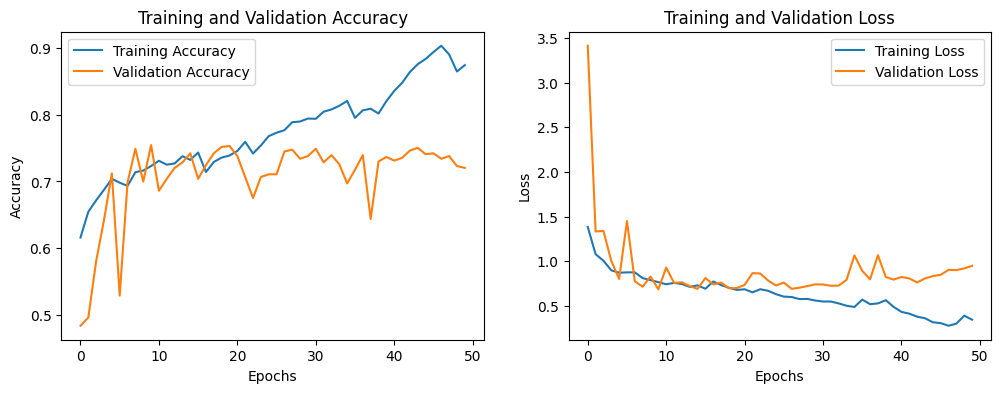

In [ ]:
# Assuming 'history' is the return value from the model.fit call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Get number of epochs

# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Base Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for Base Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Load VGG16 pre-trained on ImageNet data
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg16.trainable = False

# Add custom layers
x_vgg16 = base_model_vgg16.output
x_vgg16 = GlobalAveragePooling2D()(x_vgg16)
x_vgg16 = Dense(1024, activation='relu')(x_vgg16)
x_vgg16 = Dropout(0.5)(x_vgg16)
predictions_vgg16 = Dense(5, activation='softmax')(x_vgg16)

model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions_vgg16)
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Load InceptionV3 pre-trained on ImageNet data
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_inception.trainable = False

# Add custom layers
x_inception = base_model_inception.output
x_inception = GlobalAveragePooling2D()(x_inception)
x_inception = Dense(1024, activation='relu')(x_inception)
x_inception = Dropout(0.5)(x_inception)
predictions_inception = Dense(5, activation='softmax')(x_inception)

model_inception = Model(inputs=base_model_inception.input, outputs=predictions_inception)
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Load Xception pre-trained on ImageNet data
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_xception.trainable = False

# Add custom layers
x_xception = base_model_xception.output
x_xception = GlobalAveragePooling2D()(x_xception)
x_xception = Dense(1024, activation='relu')(x_xception)
x_xception = Dropout(0.5)(x_xception)
predictions_xception = Dense(5, activation='softmax')(x_xception)

model_xception = Model(inputs=base_model_xception.input, outputs=predictions_xception)
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Load MobileNetV2 pre-trained on ImageNet data
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobilenet.trainable = False

# Add custom layers
x_mobilenet = base_model_mobilenet.output
x_mobilenet = GlobalAveragePooling2D()(x_mobilenet)
x_mobilenet = Dense(1024, activation='relu')(x_mobilenet)
x_mobilenet = Dropout(0.5)(x_mobilenet)
predictions_mobilenet = Dense(5, activation='softmax')(x_mobilenet)

model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions_mobilenet)
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
history_vgg16 = model_vgg16.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset
)


Epoch 1/50
92/92 [==============================] - 32s 286ms/step - loss: 0.9221 - accuracy: 0.6750 - val_loss: 0.7319 - val_accuracy: 0.7353
Epoch 2/50
92/92 [==============================] - 19s 197ms/step - loss: 0.7409 - accuracy: 0.7235 - val_loss: 0.6656 - val_accuracy: 0.7749
Epoch 3/50
92/92 [==============================] - 19s 199ms/step - loss: 0.6952 - accuracy: 0.7412 - val_loss: 0.6356 - val_accuracy: 0.7585
Epoch 4/50
92/92 [==============================] - 21s 221ms/step - loss: 0.6675 - accuracy: 0.7504 - val_loss: 0.6619 - val_accuracy: 0.7599
Epoch 5/50
92/92 [==============================] - 19s 201ms/step - loss: 0.6466 - accuracy: 0.7665 - val_loss: 0.6254 - val_accuracy: 0.7503
Epoch 6/50
92/92 [==============================] - 19s 199ms/step - loss: 0.6487 - accuracy: 0.7617 - val_loss: 0.6143 - val_accuracy: 0.7681
Epoch 7/50
92/92 [==============================] - 19s 197ms/step - loss: 0.6197 - accuracy: 0.7631 - val_loss: 0.6168 - val_accuracy: 0.7790

In [ ]:
history_xception = model_xception.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset
)


Epoch 1/50
92/92 [==============================] - 30s 261ms/step - loss: 0.8992 - accuracy: 0.6845 - val_loss: 0.7129 - val_accuracy: 0.7585
Epoch 2/50
92/92 [==============================] - 18s 191ms/step - loss: 0.7140 - accuracy: 0.7381 - val_loss: 0.6215 - val_accuracy: 0.7667
Epoch 3/50
92/92 [==============================] - 19s 200ms/step - loss: 0.6725 - accuracy: 0.7569 - val_loss: 0.6496 - val_accuracy: 0.7640
Epoch 4/50
92/92 [==============================] - 19s 198ms/step - loss: 0.6284 - accuracy: 0.7692 - val_loss: 0.5956 - val_accuracy: 0.7749
Epoch 5/50
92/92 [==============================] - 21s 221ms/step - loss: 0.6262 - accuracy: 0.7665 - val_loss: 0.5850 - val_accuracy: 0.7708
Epoch 6/50
92/92 [==============================] - 19s 203ms/step - loss: 0.6032 - accuracy: 0.7771 - val_loss: 0.5871 - val_accuracy: 0.7708
Epoch 7/50
92/92 [==============================] - 21s 218ms/step - loss: 0.6021 - accuracy: 0.7753 - val_loss: 0.5906 - val_accuracy: 0.7708

In [ ]:
history_mobilenet = model_mobilenet.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset
)


Epoch 1/50
92/92 [==============================] - 23s 197ms/step - loss: 0.9988 - accuracy: 0.6760 - val_loss: 0.6764 - val_accuracy: 0.7422
Epoch 2/50
92/92 [==============================] - 17s 175ms/step - loss: 0.6657 - accuracy: 0.7559 - val_loss: 0.6462 - val_accuracy: 0.7490
Epoch 3/50
92/92 [==============================] - 17s 175ms/step - loss: 0.6226 - accuracy: 0.7675 - val_loss: 0.5889 - val_accuracy: 0.7667
Epoch 4/50
92/92 [==============================] - 19s 203ms/step - loss: 0.5816 - accuracy: 0.7794 - val_loss: 0.5616 - val_accuracy: 0.7899
Epoch 5/50
92/92 [==============================] - 17s 174ms/step - loss: 0.5595 - accuracy: 0.7969 - val_loss: 0.5523 - val_accuracy: 0.7926
Epoch 6/50
92/92 [==============================] - 17s 182ms/step - loss: 0.5247 - accuracy: 0.7955 - val_loss: 0.5544 - val_accuracy: 0.7899
Epoch 7/50
92/92 [==============================] - 17s 176ms/step - loss: 0.5194 - accuracy: 0.7965 - val_loss: 0.5922 - val_accuracy: 0.7776

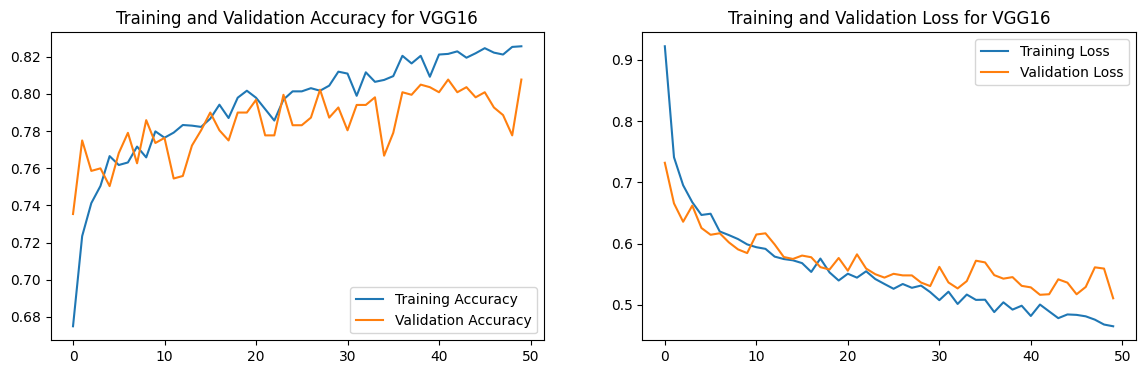

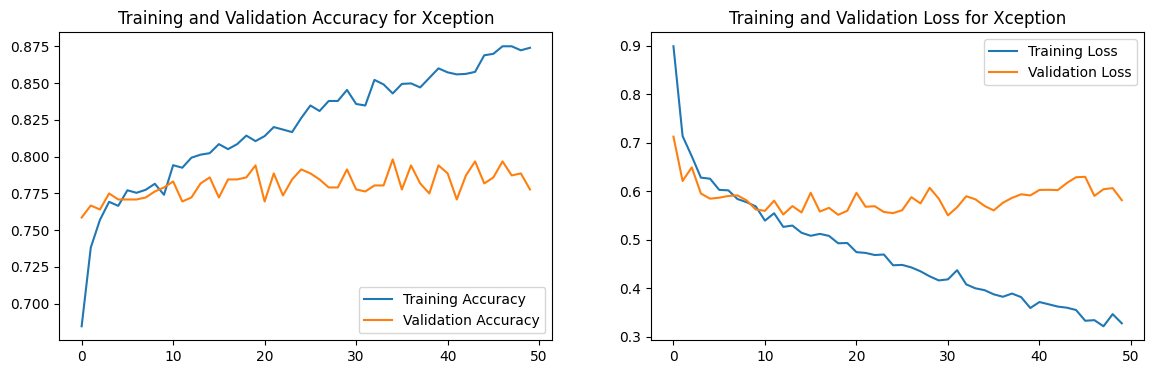

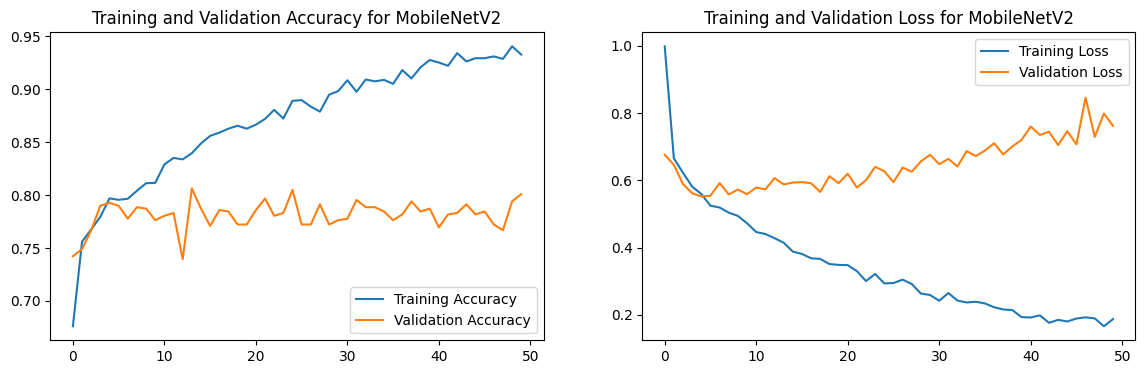

In [ ]:
def plot_model_performance(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend(loc='upper right')

    plt.show()

# Plot for each model
plot_model_performance(history_vgg16, "VGG16")

plot_model_performance(history_xception, "Xception")
plot_model_performance(history_mobilenet, "MobileNetV2")


In [ ]:
# # Saving model1
# model1.save('/content/drive/MyDrive/Rotation/Models/Colored/base_model_c.h5')

# # Saving VGG16 Model
# model_vgg16.save('/content/drive/MyDrive/Rotation/Models/Colored/vgg16_model_c.h5')

# # Saving InceptionV3 Model
# model_inception.save('/content/drive/MyDrive/Rotation/Models/Colored/inception_model_c.h5')

# # Saving Xception Model
# model_xception.save('/content/drive/MyDrive/Rotation/Models/Colored/xception_model_c.h5')

# # Saving MobileNetV2 Model
# model_mobilenet.save('/content/drive/MyDrive/Rotation/Models/Colored/mobilenet_model_c.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_vgg16 = load_model('/content/drive/MyDrive/Rotation/Models/Colored/vgg16_model_c.h5')
model_vgg16._name = 'VGG16'

model_inception = load_model('/content/drive/MyDrive/Rotation/Models/Colored/inception_model_c.h5')
model_inception._name = 'InceptionV3'

model_xception = load_model('/content/drive/MyDrive/Rotation/Models/Colored/xception_model_c.h5')
model_xception._name = 'Xception'

model_mobilenet = load_model('/content/drive/MyDrive/Rotation/Models/Colored/mobilenet_model_c.h5')
model_mobilenet._name = 'MobileNetV2'

model1 = load_model('/content/drive/MyDrive/Rotation/Models/Colored/base_model_c.h5')
model1._name = 'CustomModel1'


In [ ]:
# Evaluate the models
vgg16_eval = model_vgg16.evaluate(validation_dataset)
inception_eval = model_inception.evaluate(validation_dataset)
xception_eval = model_xception.evaluate(validation_dataset)
mobilenet_eval = model_mobilenet.evaluate(validation_dataset)
model1_eval = model1.evaluate(validation_dataset)

print("VGG16 Accuracy:", vgg16_eval[1])
print("InceptionV3 Accuracy:", inception_eval[1])
print("Xception Accuracy:", xception_eval[1])
print("MobileNetV2 Accuracy:", mobilenet_eval[1])
print("Model1 Accuracy:", model1_eval[1])

23/23 [==============================] - 4s 150ms/step - loss: 0.9560 - accuracy: 0.7244
VGG16 Accuracy: 0.8076398372650146
InceptionV3 Accuracy: 0.058663029223680496
Xception Accuracy: 0.788540244102478
MobileNetV2 Accuracy: 0.7994542717933655
Model1 Accuracy: 0.7244201898574829


In [ ]:
# Define image paths and their corresponding original class names
image_info = [
    {'path': '/content/drive/MyDrive/Rotation/Colored/val/Mild/01b3aed3ed4c.png', 'original_class': 'Mild'},
    {'path': '/content/drive/MyDrive/Rotation/Colored/val/Moderate/00e4ddff966a.png', 'original_class': 'Moderate'},
    {'path': '/content/drive/MyDrive/Rotation/Colored/val/No_DR/005b95c28852.png', 'original_class': 'No_DR'},
    {'path': '/content/drive/MyDrive/Rotation/Colored/val/Proliferate_DR/02685f13cefd.png', 'original_class': 'Proliferate_DR'},
    {'path': '/content/drive/MyDrive/Rotation/Colored/val/Severe/03c85870824c.png', 'original_class': 'Severe'}
    # Add more images and their classes as needed
]
# Assuming class_names and image_info are already defined
# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Normalize to [0,1]
    return img_array

class_names = {
    0: 'Mild',
    1: 'Moderate',
    2: 'No_DR',
    3: 'Proliferate_DR',
    4: 'Severe'
}



In [ ]:

# Assuming class_names and image_info are already defined

# Loop through each model and each image, make predictions, and compare with the original class
for model in [model_vgg16, model_inception, model_xception, model_mobilenet, model1]:
    correct_predictions = 0
    total_images = len(image_info)

    print(f"\nPredictions using {model.name}:")
    for info in image_info:
        img = load_and_preprocess_image(info['path'])
        prediction = model.predict(img)
        predicted_class_index = np.argmax(prediction, axis=1)[0]  # Assuming a single prediction
        predicted_class_name = class_names[predicted_class_index]

        # Compare the predicted class with the original class
        if predicted_class_name == info['original_class']:
            correct_predictions += 1
            result = "Correct"
        else:
            result = "Wrong"
        print(f"Original Class: {info['original_class']}, Predicted Class: {predicted_class_name} - {result}")

    # Print the summary for each model
    print(f"Out of {total_images} images, {correct_predictions} are correct.")




Predictions using VGG16:
1/1 [==============================] - 2s 2s/step
Original Class: Mild, Predicted Class: No_DR - Wrong
1/1 [==============================] - 0s 18ms/step
Original Class: Moderate, Predicted Class: Moderate - Correct
1/1 [==============================] - 0s 18ms/step
Original Class: No_DR, Predicted Class: No_DR - Correct
1/1 [==============================] - 0s 18ms/step
Original Class: Proliferate_DR, Predicted Class: No_DR - Wrong
1/1 [==============================] - 0s 26ms/step
Original Class: Severe, Predicted Class: No_DR - Wrong
Out of 5 images, 2 are correct.

Predictions using InceptionV3:
1/1 [==============================] - 3s 3s/step
Original Class: Mild, Predicted Class: Severe - Wrong
1/1 [==============================] - 0s 37ms/step
Original Class: Moderate, Predicted Class: Proliferate_DR - Wrong
1/1 [==============================] - 0s 37ms/step
Original Class: No_DR, Predicted Class: Severe - Wrong
1/1 [=============================

In [ ]:
# model_vgg16 = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/vgg16_model_g.h5')
# model_vgg16._name = 'VGG16'

# model_inception = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/inception_model_g.h5')
# model_inception._name = 'InceptionV3'

# model_xception = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/xception_model_g.h5')
# model_xception._name = 'Xception'

# model_mobilenet = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/mobilenet_model_g.h5')
# model_mobilenet._name = 'MobileNetV2'

# model1 = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/base_model_g.h5')
# model1._name = 'CustomModel1'

In [ ]:

# Assuming class_names and image_info are already defined

# Loop through each model and each image, make predictions, and compare with the original class
for model in [model_vgg16, model_inception, model_xception, model_mobilenet, model1]:
    correct_predictions = 0
    total_images = len(image_info)

    print(f"\nPredictions using {model.name}:")
    for info in image_info:
        img = load_and_preprocess_image(info['path'])
        prediction = model.predict(img)
        predicted_class_index = np.argmax(prediction, axis=1)[0]  # Assuming a single prediction
        predicted_class_name = class_names[predicted_class_index]

        # Compare the predicted class with the original class
        if predicted_class_name == info['original_class']:
            correct_predictions += 1
            result = "Correct"
        else:
            result = "Wrong"
        print(f"Original Class: {info['original_class']}, Predicted Class: {predicted_class_name} - {result}")

    # Print the summary for each model
    print(f"Out of {total_images} images, {correct_predictions} are correct.")




Predictions using VGG16:
1/1 [==============================] - 0s 132ms/step
Original Class: Mild, Predicted Class: Mild - Correct
1/1 [==============================] - 0s 21ms/step
Original Class: Moderate, Predicted Class: Moderate - Correct
1/1 [==============================] - 0s 18ms/step
Original Class: No_DR, Predicted Class: No_DR - Correct
1/1 [==============================] - 0s 20ms/step
Original Class: Proliferate_DR, Predicted Class: Moderate - Wrong
1/1 [==============================] - 0s 18ms/step
Original Class: Severe, Predicted Class: Mild - Wrong
Out of 5 images, 3 are correct.

Predictions using InceptionV3:
1/1 [==============================] - 1s 1s/step
Original Class: Mild, Predicted Class: Mild - Correct
1/1 [==============================] - 0s 25ms/step
Original Class: Moderate, Predicted Class: Mild - Wrong
1/1 [==============================] - 0s 25ms/step
Original Class: No_DR, Predicted Class: Mild - Wrong
1/1 [==============================] - 0

In [ ]:
# model_vgg16 = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/vgg16_model_g.h5')
# model_vgg16._name = 'VGG16'

# model_xception = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/xception_model_g.h5')
# model_xception._name = 'Xception'

model = model_vgg16


def preprocess_input_custom(x):
    return preprocess_input(x)

gradcam = Gradcam(model, model_modifier=None, clone=True)
gradcam_plus_plus = GradcamPlusPlus(model, model_modifier=None, clone=True)
saliency = Saliency(model, model_modifier=None, clone=True)


In [ ]:
for layer in model_vgg16.layers:
    if 'conv' in layer.name:
        print(layer.name)

block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block4_conv1
block4_conv2
block4_conv3
block5_conv1
block5_conv2
block5_conv3


1/1 [==============================] - 0s 29ms/step


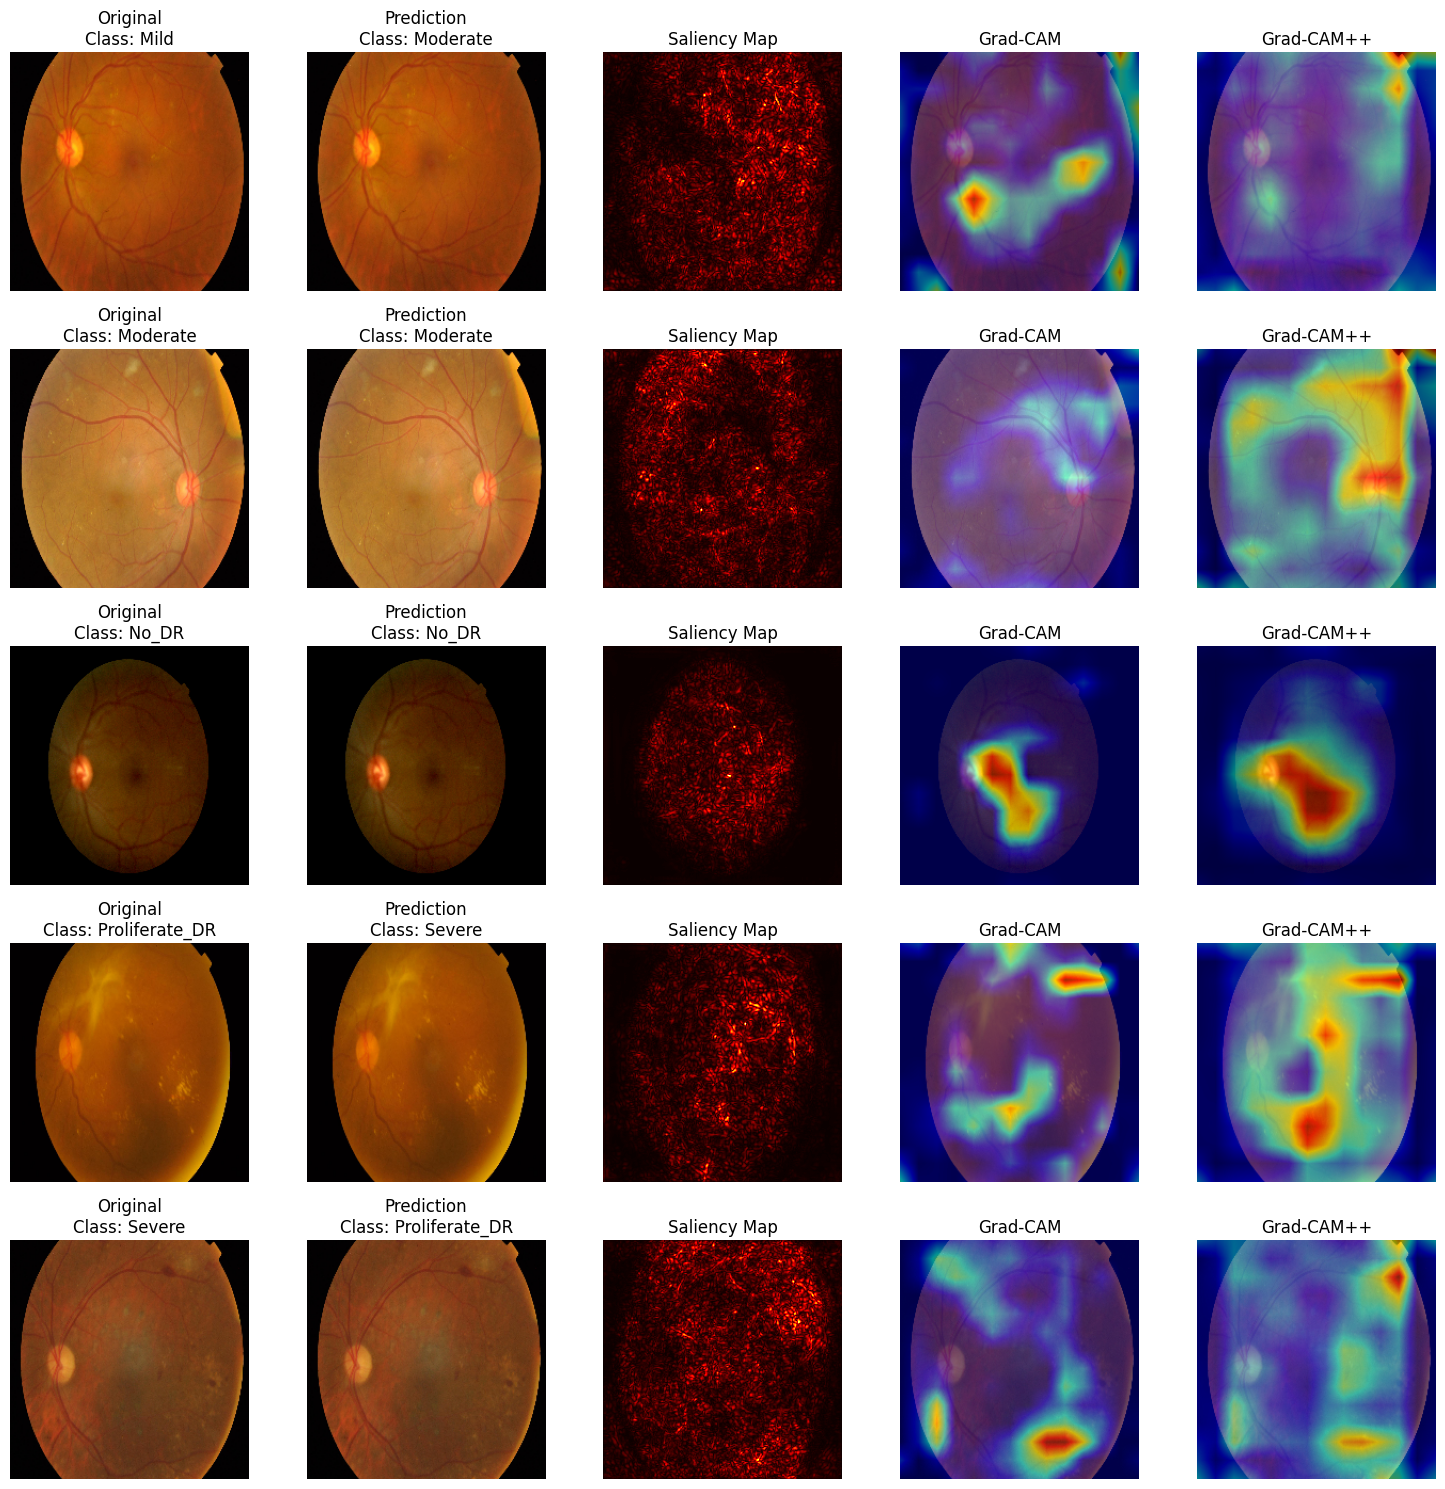

In [ ]:
layer_name = 'block5_conv3'

fig, axs = plt.subplots(len(image_info), 5, figsize=(15, len(image_info) * 3), squeeze=False)

for i, info in enumerate(image_info):
    img_path = info['path']
    original_class = info['original_class']

    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_custom(x)

    prediction = model.predict(x)
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    try:
        predicted_class = class_names[predicted_class_index]
    except KeyError:
        print(f"Invalid class index: {predicted_class_index}")
        continue

    def score_function(output):
        return output[0][predicted_class_index]


    cam = gradcam(score_function, x, penultimate_layer=layer_name)  # Replace None with your model layer
    cam = normalize(cam)

    cam_plus_plus = gradcam_plus_plus(score_function, x, penultimate_layer=layer_name)  # Replace None with your model layer
    cam_plus_plus = normalize(cam_plus_plus)

    saliency_map = saliency(score_function, x)
    saliency_map = normalize(saliency_map)

    # Heatmap generation
    heatmap = cv2.applyColorMap(np.uint8(255 * cam[0]), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    img_with_heatmap = np.float32(heatmap) + np.float32(img)
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)

    heatmap_plus_plus = cv2.applyColorMap(np.uint8(255 * cam_plus_plus[0]), cv2.COLORMAP_JET)
    heatmap_plus_plus = cv2.cvtColor(heatmap_plus_plus, cv2.COLOR_BGR2RGB)
    img_with_heatmap_plus_plus = np.float32(heatmap_plus_plus) + np.float32(img)
    img_with_heatmap_plus_plus = img_with_heatmap_plus_plus / np.max(img_with_heatmap_plus_plus)

    # Displaying images and maps
    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Original\nClass: {original_class}')

    axs[i, 1].imshow(img)
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Prediction\nClass: {predicted_class}')

    axs[i, 2].imshow(saliency_map[0], cmap='hot')
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Saliency Map')

    axs[i, 3].imshow(img_with_heatmap)
    axs[i, 3].axis('off')
    axs[i, 3].set_title('Grad-CAM')

    axs[i, 4].imshow(img_with_heatmap_plus_plus)
    axs[i, 4].axis('off')
    axs[i, 4].set_title('Grad-CAM++')

plt.tight_layout()
plt.show()



In [ ]:



class_names = ["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]

# Models
models = {
    'VGG16': model_vgg16,
    'InceptionV3': model_inception,
    'Xception': model_xception,
    'MobileNetV2': model_mobilenet,
    'CustomModel1': model1
}
# Function to extract true labels from the validation dataset
def get_true_labels(validation_dataset):
    true_labels = []
    for images, labels in validation_dataset:
        true_labels.extend(labels.numpy().argmax(axis=1))
    return np.array(true_labels)

# Function to predict labels using a model
def predict(model, validation_dataset):
    predictions = model.predict(validation_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

# Get true labels
true_labels = get_true_labels(validation_dataset)



# Function to predict labels using a model
def predict(model, validation_dataset):
    predictions = model.predict(validation_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

23/23 [==============================] - 11s 307ms/step


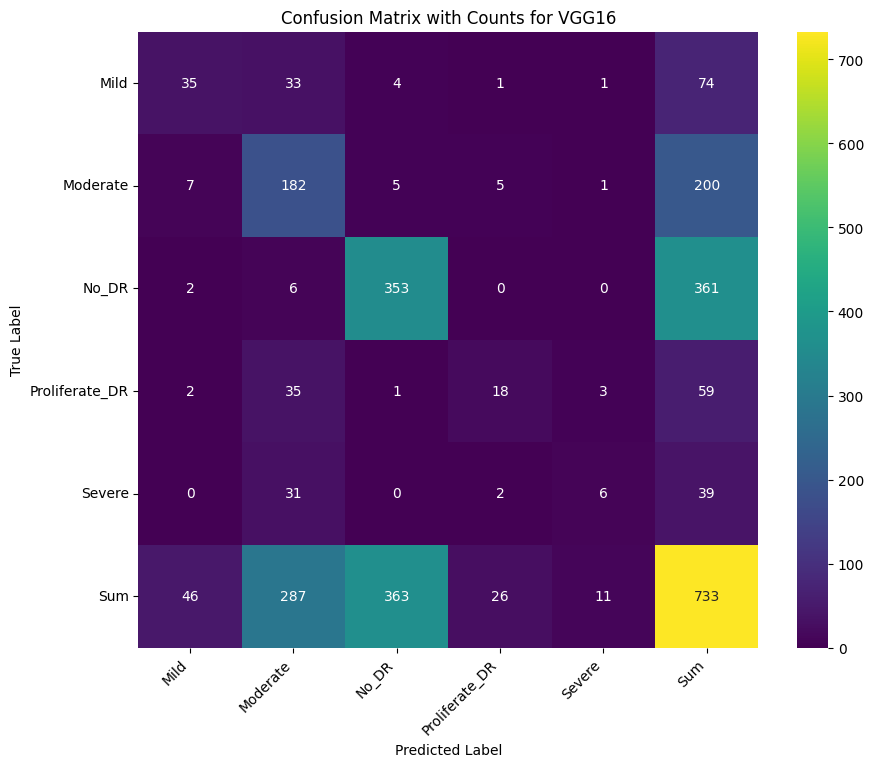

23/23 [==============================] - 9s 261ms/step


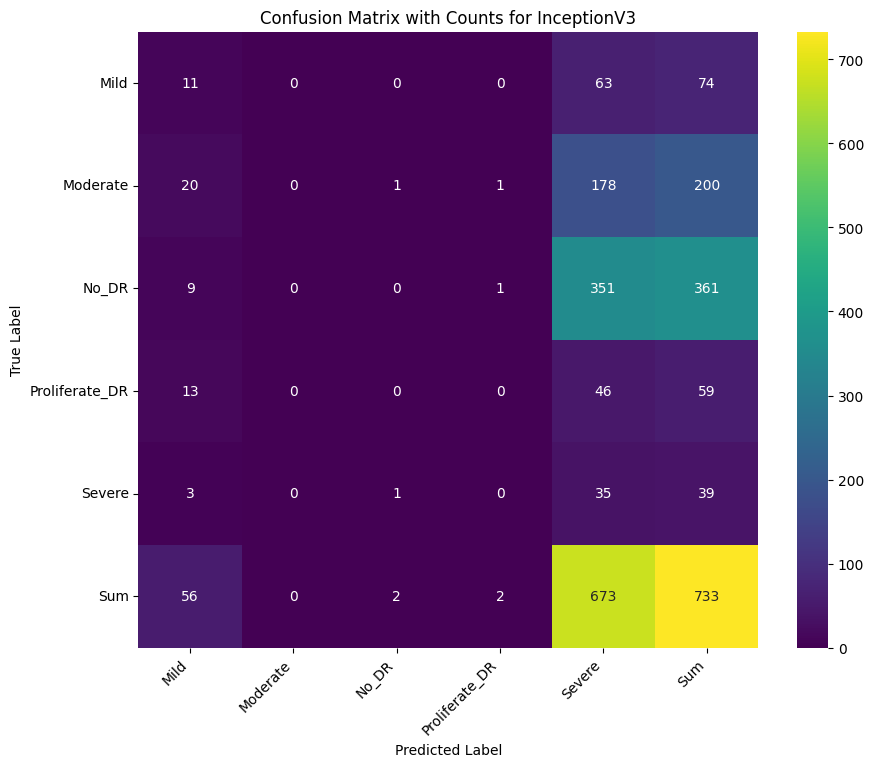

23/23 [==============================] - 8s 217ms/step


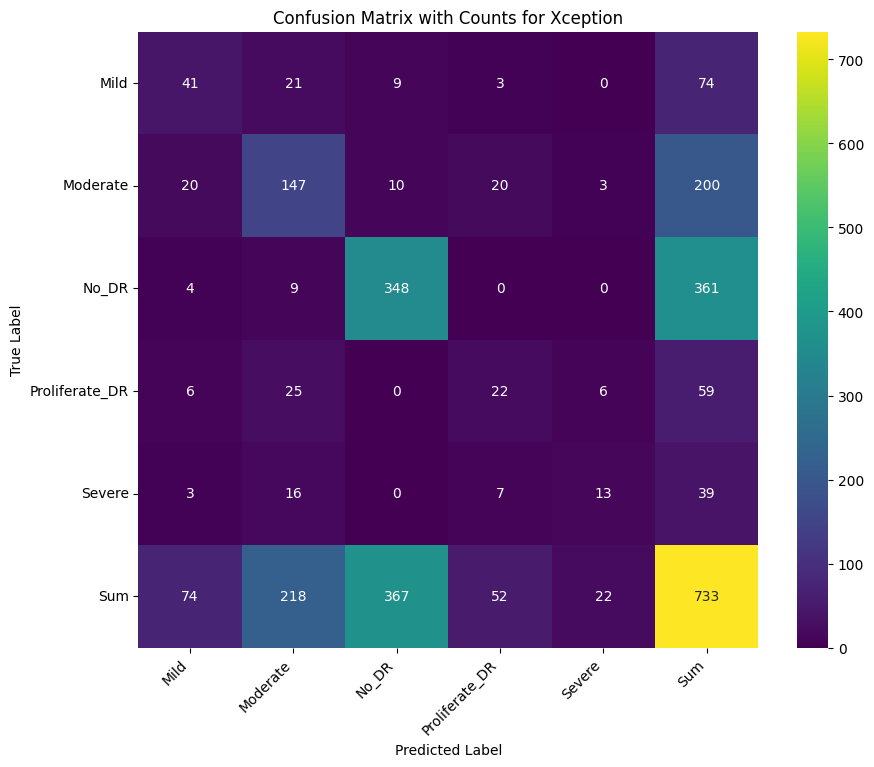

23/23 [==============================] - 6s 196ms/step


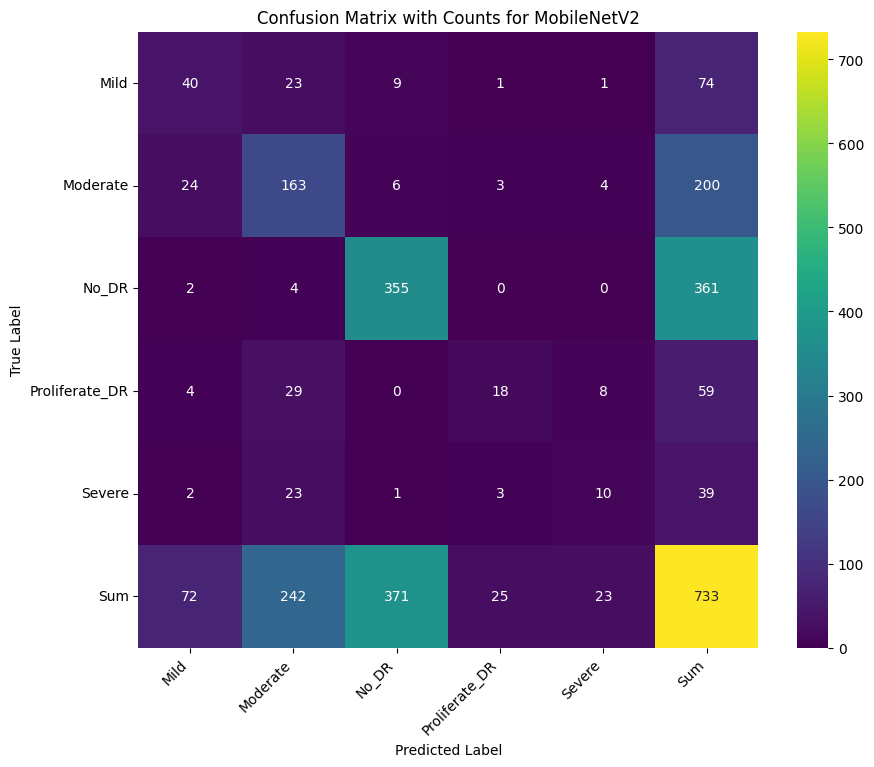

23/23 [==============================] - 4s 144ms/step


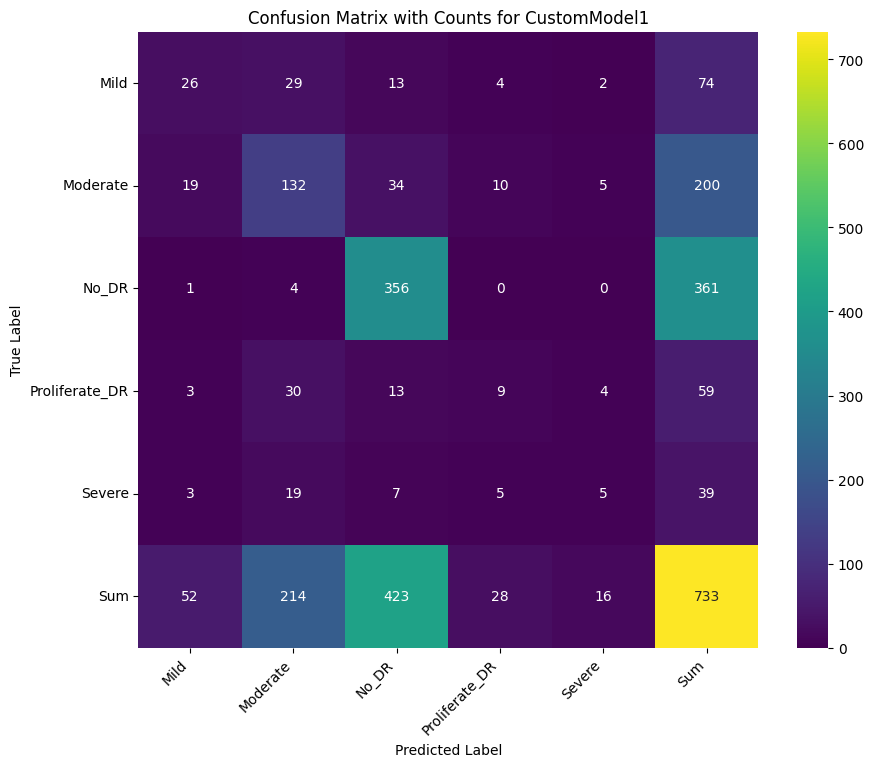

In [ ]:


# Iterate over models and plot confusion matrices
for model_name, model in models.items():
    predictions = predict(model, validation_dataset)
    cm = confusion_matrix(true_labels, predictions, labels=range(len(class_names)))
    cm_with_counts = np.c_[cm, cm.sum(axis=1)]
    cm_with_counts = np.r_[cm_with_counts, [cm_with_counts.sum(axis=0)]]

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cm_with_counts, annot=True, fmt='g', cmap='viridis')
    ax.set_title(f'Confusion Matrix with Counts for {model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    # Set the class names as tick labels
    ax.set_xticklabels(class_names + ['Sum'], rotation=45, ha="right")
    ax.set_yticklabels(class_names + ['Sum'], rotation=0)
    plt.show()


23/23 [==============================] - 4s 160ms/step


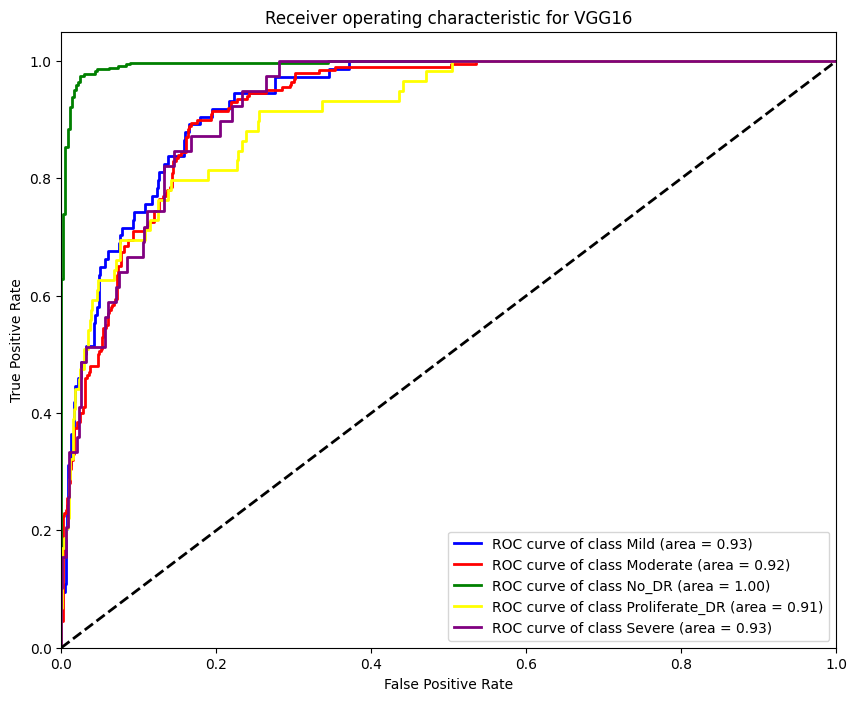

23/23 [==============================] - 4s 180ms/step


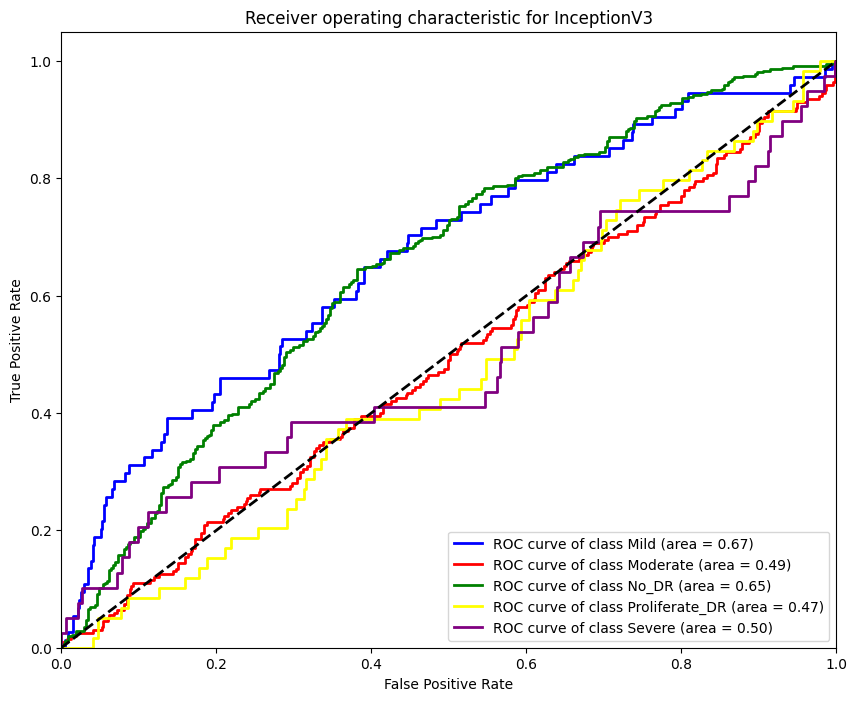

23/23 [==============================] - 4s 172ms/step


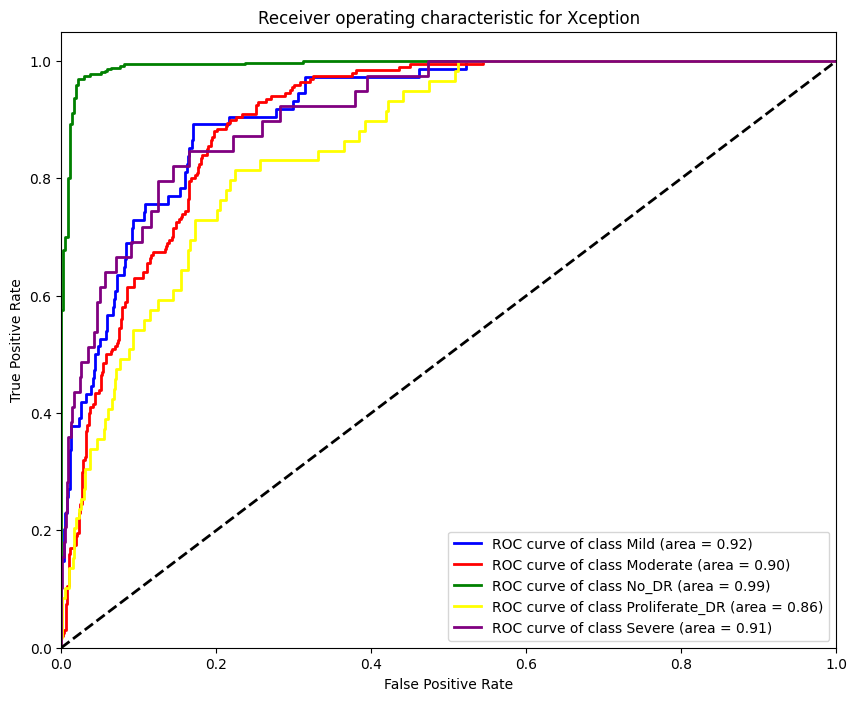

23/23 [==============================] - 3s 143ms/step


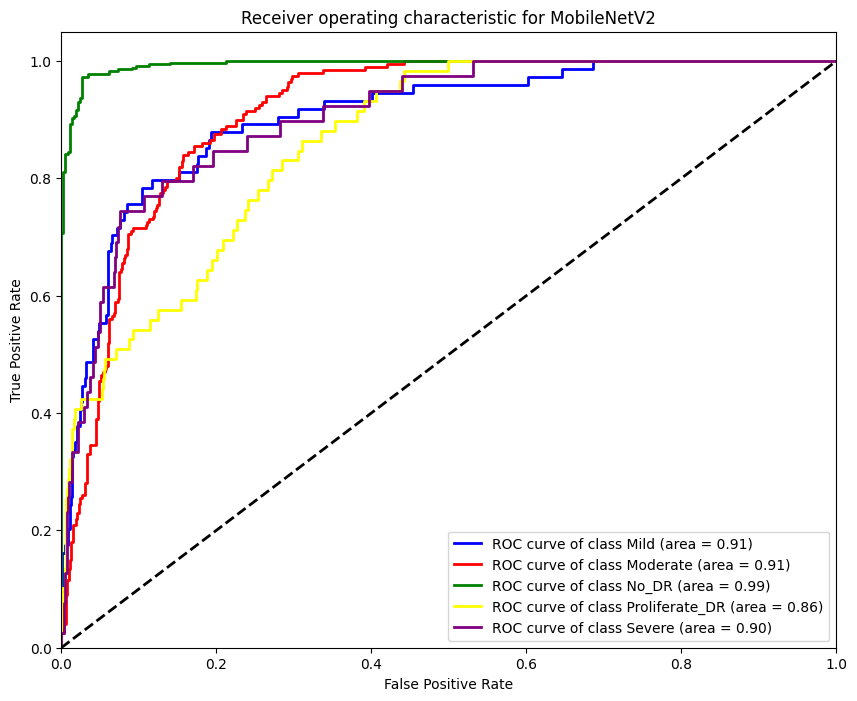

23/23 [==============================] - 3s 137ms/step


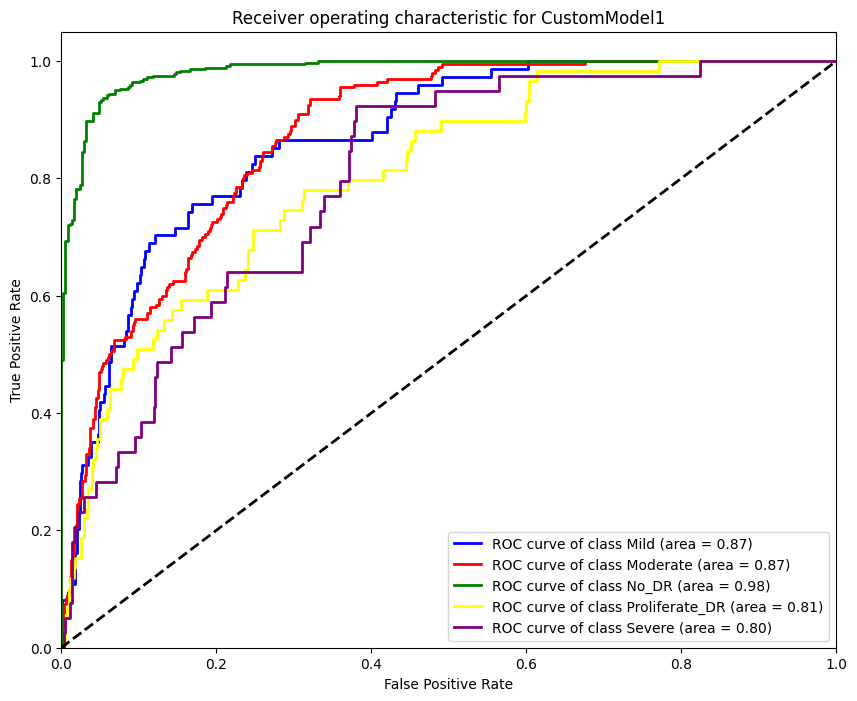

In [ ]:
# Class names and number of classes
from itertools import cycle
class_names = ["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]
n_classes = len(class_names)

# Models
models = {
    'VGG16': model_vgg16,
    'InceptionV3': model_inception,
    'Xception': model_xception,
    'MobileNetV2': model_mobilenet,
    'CustomModel1': model1
}

# Function to plot ROC curve
def plot_roc_curve(y_test, y_score, n_classes, class_names, model_name):
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

# Iterate over models and plot ROC curve
for model_name, model in models.items():
    # Get true labels and predictions
    y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
    y_true = np.argmax(y_true, axis=1)
    y_score = model.predict(validation_dataset)

    plot_roc_curve(y_true, y_score, n_classes, class_names, model_name)


In [ ]:
train_features_flat = np.reshape(train_features, (train_features.shape[0], -1))
validation_features_flat = np.reshape(validation_features, (validation_features.shape[0], -1))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_features_flat, np.argmax(train_labels, axis=1))

# SVM
svm = SVC(gamma='auto')
svm.fit(train_features_flat, np.argmax(train_labels, axis=1))


SVC(gamma='auto')

In [ ]:
# Xecpton model evaluation
model_vgg16 = model_vgg16.evaluate(validation_dataset)[1]

# Random Forest evaluation
rf_accuracy = rf.score(validation_features_flat, np.argmax(validation_labels, axis=1))

# SVM evaluation
svm_accuracy = svm.score(validation_features_flat, np.argmax(validation_labels, axis=1))

print(f"Xception Model Accuracy: {model_vgg16}")
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")

23/23 [==============================] - 3s 134ms/step - loss: 2.0056 - accuracy: 0.4611
Xception Model Accuracy: 0.4611186981201172
Random Forest Accuracy: 0.7435197817189632
SVM Accuracy: 0.7394270122783083
